In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from cvxopt import matrix, solvers
from scipy.optimize import minimize

In [2]:
# Read data into pandas
japan = pd.read_excel("./data/Price History_EWJ_Japan_Equity.xlsx")
t_bills_7_10 = pd.read_excel("./data/Price History_7-10_US_TBills.xlsx")
t_bills_20 = pd.read_excel("./data/Price History_20+_US_TBills.xlsx")
apac_x_japan = pd.read_excel("./data/Price History_EPP_APACxJapan_Equity.xlsx")
europe = pd.read_excel("./data/Price History_IEV_Europe_Equity.xlsx")
latam = pd.read_excel("./data/Price History_ILF_LatAm_Equity.xlsx")
us = pd.read_excel("./data/Price History_IVV_US_Equity.xlsx")
gold = pd.read_excel("./data/Price History_IAU_Gold_Trust.xlsx")

In [3]:
def preprocess_and_rename(df, name):
    df['Exchange Date'] = pd.to_datetime(df['Exchange Date'])
    df.set_index('Exchange Date', inplace=True)
    df.rename(columns={'%Chg':f'Return {name}'}, inplace=True)
    return df[[f'Return {name}']]

# Preprocess all datasets and rename columns
japan = preprocess_and_rename(japan, 'Japan')
t_bills_7_10 = preprocess_and_rename(t_bills_7_10, 'T-Bills_7_10')
t_bills_20 = preprocess_and_rename(t_bills_20, 'T-Bills_20')
apac_x_japan = preprocess_and_rename(apac_x_japan, 'APACxJapan')
europe = preprocess_and_rename(europe, 'Europe')
latam = preprocess_and_rename(latam, 'LatAm')
us = preprocess_and_rename(us, 'US')
gold = preprocess_and_rename(gold, 'Gold')

In [4]:
us

,Return US
Exchange Date,
2024-12-13,-0.000181
2024-12-12,-0.005306
2024-12-11,0.007707
2024-12-10,-0.002896
2024-12-09,-0.005157
...,...
2005-01-07,-0.001852
2005-01-06,0.004058
2005-01-05,-0.006050


In [5]:
# Merge all datasets on 'Exchange Date'
returns = japan.join([t_bills_7_10, t_bills_20, apac_x_japan, europe, latam, us, gold], how='inner')

# Rename the columns for clarity
returns.columns = ['Japan', 'T-Bills_7_10', 'T-Bills_20', 
                'APACxJapan','Europe','LatAm', 'US', 'Gold']
returns = returns.dropna()
returns = returns.sort_values(by='Exchange Date', ascending=True)

In [6]:
returns

,Japan,T-Bills_7_10,T-Bills_20,APACxJapan,Europe,LatAm,US,Gold
Exchange Date,,,,,,,,
2005-01-31,0.000000,0.000350,0.002843,0.002793,0.004750,0.017648,0.008956,-0.009838
2005-02-01,0.005666,-0.003734,-0.005343,0.008802,0.010265,0.013544,0.006425,-0.003549
2005-02-02,0.003756,0.000117,0.002302,0.000884,-0.000668,0.009117,0.003192,0.002612
2005-02-03,-0.014967,-0.001757,-0.000875,-0.008056,-0.002676,0.010767,-0.001758,-0.012077
2005-02-04,0.004748,0.005280,0.014231,0.007231,0.003622,0.017877,0.009646,-0.005273
...,...,...,...,...,...,...,...,...
2024-12-09,-0.008723,-0.003464,-0.009217,0.018423,-0.001273,0.012993,-0.005157,0.009863
2024-12-10,-0.005393,-0.001791,-0.004705,-0.016197,-0.008379,0.000855,-0.002896,0.013155
2024-12-11,0.014127,-0.002955,-0.009454,0.000000,0.004041,0.015805,0.007707,0.009247


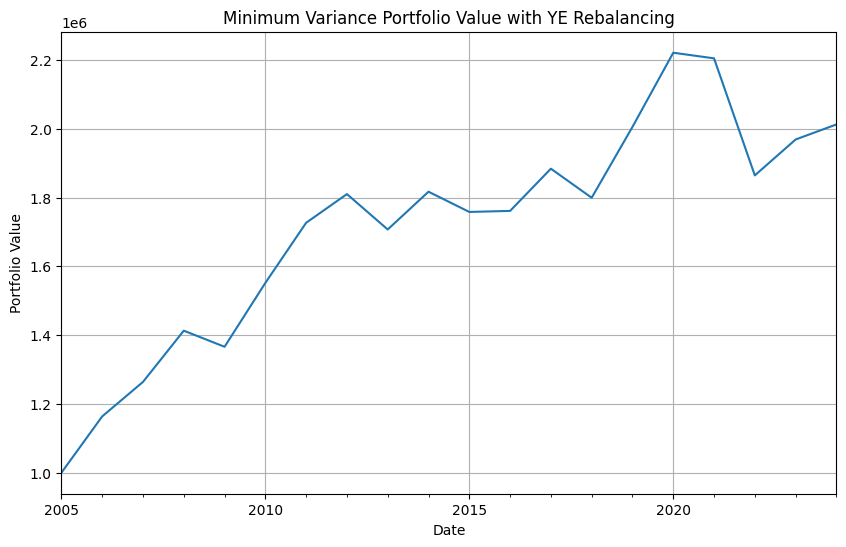

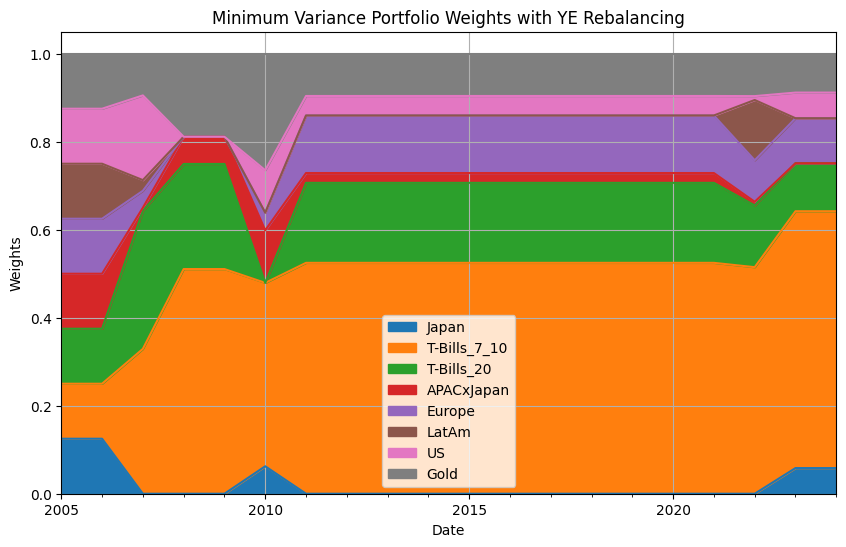

In [40]:
#### Min Var Portfolio Construction ####

# Helper to calculate portfolio variance
def calc_portfolio_variance(w, covariance_matrix):
    # Portfolio variance = w^T * Covariance Matrix * w
    return np.dot(w.T, np.dot(covariance_matrix, w))

# Helper for weight constraint
def total_weight_constraint(w):
    return np.sum(w) - 1  # Total weights must sum to 1

# Portfolio optimization function to minimize variance
def min_variance_optimizer(cov_matrix, w0):
    # Define constraints: weights sum to 1 and long-only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    bounds = [(0, 1) for _ in range(len(returns.columns))]
    # Use scipy's minimize function to find the weights that minimize the portfolio variance
    res = minimize(calc_portfolio_variance, w0, args=(cov_matrix,), bounds=bounds, constraints=cons, method='SLSQP', options = {'ftol':1e-8}) #ftol is a very important variable, test!!!
    return res

# Main function to calculate minimum variance portfolio over time
def min_variance_portfolio(returns, rebalance_frequency, initial_investment=1e6):
    # Resample returns based on rebalancing frequency (monthly, quarterly, etc.)
    resampled_returns = returns.resample(rebalance_frequency).apply(lambda x: (x + 1).prod() - 1)

    # Initialize portfolio value
    portfolio_value = pd.Series(index=resampled_returns.index, data=np.nan)
    portfolio_value.iloc[0] = initial_investment
    # Define initial weights to be 1/n
    w0 = np.ones(returns.shape[1]) / returns.shape[1]
    # Store portfolio weights for tracking
    portfolio_weights = pd.DataFrame(index=resampled_returns.index, columns=returns.columns)
    portfolio_weights.iloc[0] = w0
    
    # Loop through the resampled returns to rebalance
    for i in range(1, len(resampled_returns)):
        #1 Determine the actual rebalancing window (last quarter of daily returns)
        rebal_start = resampled_returns.index[i-1]
        rebal_end = resampled_returns.index[i]

        #2 Specify timeframe for covariance calculation starting from REBAL_END
        lookback_days = 252/12
        cov_start = rebal_end - pd.DateOffset(days=lookback_days)
        cov_data = returns.loc[cov_start : rebal_end]

        # Skip if there is not enough data (e.g., Na's)
        if cov_data.isna().any().any() or len(cov_data) < 2:
            print(f"Skipping period {resampled_returns.index[i]} due to insufficient data.")
            continue
        
        #3 Calculate covariance matrix for the daily returns of the #2 specified period
        covariance_matrix = cov_data.cov().values
        #4 Optimize portfolio weights based on minimum variance
        res = min_variance_optimizer(covariance_matrix, w0)
        if not res.success:
            print(f"Optimization failed at {resampled_returns.index[i]}")
            continue

        optimal_weights = res.x
        assert np.isclose(np.sum(optimal_weights), 1), "Weights do not sum to 1."
        assert all(0 <= w <= 1 for w in optimal_weights), "Weights are not within the bounds."
        portfolio_weights.iloc[i] = optimal_weights
        
        #5 Calculate actual portfolio return for just the last period
        current_period = returns.loc[rebal_start:rebal_end]
        cumulative_returns = current_period.apply(lambda x: (x + 1).prod() - 1, axis=0)
        portfolio_return = np.dot(optimal_weights, cumulative_returns)

        #6 Update portfolio value (assuming no transaction costs)
        portfolio_value.iloc[i] = portfolio_value.iloc[i-1] * (1 + portfolio_return)

        w0 = optimal_weights

    return portfolio_value, portfolio_weights

#### Actual Fuction Call ####

rebalance_frequency = 'YE'  # ME = monthly, QE = quarterly, YE = yearly
portfolio_value, portfolio_weights = min_variance_portfolio(returns, rebalance_frequency)

# Plot the portfolio value over time
portfolio_value.plot(figsize=(10, 6))
plt.title(f'Minimum Variance Portfolio Value with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()

# Plot the portfolio weights over time
portfolio_weights.plot(figsize=(10, 6), kind='area', stacked=True)
plt.title(f'Minimum Variance Portfolio Weights with {rebalance_frequency} Rebalancing')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.grid(True)
plt.show()


In [41]:
#### Min Var Portfolio Analytics ####

# 1) Resample to monthly frequency and calculate monthly returns
monthly_portfolio_value_minvar = portfolio_value.resample('ME').ffill()
monthly_returns_minvar = monthly_portfolio_value_minvar.pct_change().dropna()

# 2) Full sample annualized monthly volatility
full_sample_monthly_vol = monthly_returns_minvar.std()
annualized_vol = full_sample_monthly_vol * np.sqrt(12)

# 3) Total return & Geo means
initial_val = portfolio_value.iloc[0]
final_val = portfolio_value.iloc[-1]
total_return_minvar = (final_val - initial_val) / initial_val

n_months = len(monthly_returns_minvar)
geo_avg_monthly_return_minvar = (final_val / initial_val) ** (1 / n_months) - 1
geo_avg_yearly_return_minvar = (1 + geo_avg_monthly_return_minvar) ** 12 - 1

# 5) Sharpe Ratio
arithmetic_monthly_return = monthly_returns_minvar.mean()  # Arithmetic mean of monthly returns
annualized_arithmetic_return = arithmetic_monthly_return * 12  # Annualized arithmetic return
sharpe_ratio_minvar = annualized_arithmetic_return / annualized_vol

# 6) Monthly 99% VaR
VaR_99_minvar = monthly_returns_minvar.quantile(1 - 0.99)

# 7) Print results
print("### Minimum Variance Portfolio Analytics ###")
print(f"Full-sample annualized monthly volatility: {annualized_vol:.4f}")
print(f"Total return: {total_return_minvar * 100:.2f}%")

print(f"Geometric avg monthly return (CAGR basis): {geo_avg_monthly_return_minvar * 100:.2f}%")
print(f"Geometric avg yearly return (CAGR basis): {geo_avg_yearly_return_minvar * 100:.2f}%")

print(f"Sharpe Ratio (Arithmetic Return / Annualized Vol): {sharpe_ratio_minvar:.2f}")
print(f"Monthly 99% Value at Risk (VaR): {VaR_99_minvar:.4f}")


### Minimum Variance Portfolio Analytics ###
Full-sample annualized monthly volatility: 0.0883
Total return: 101.24%
Geometric avg monthly return (CAGR basis): 0.31%
Geometric avg yearly return (CAGR basis): 3.75%
Sharpe Ratio (Arithmetic Return / Annualized Vol): 0.46
Monthly 99% Value at Risk (VaR): -0.0417
